In [1]:
%matplotlib inline

<img src="./pics/c9e59b2f85ae246ccdca754c1e71ce69.jpg"  width="100" height= "100" align = "right"/>
# <font color=darkblue>DSCI 521 Project</font>
## <font color=darkred>*Musical Features Prediction Using Machine Learning Algorithms* </font>
#### <font color= darkgreen>*Using Audio Data Extracted From Free Music Archive Website* <br /> </font>
[Kiana Montazeri](https://github.com/kianamon)<sup>1</sup>, [Farnaz Ghashami](https://github.com/FarnazGhashami)<sup>1</sup>,
[Shideh Shams Amiri](https://github.com/shidehsh)<sup>1</sup>.<br>
<sup>1</sup>[Drexel University, Philadelphia, PA](https://drexel.edu/cci/academics/information-science-department/)

**<font color=blue>ReadMe:</font>**
**To start, please take a look at [here](https://github.com/kianamon/MusicalFeaturesPrediction/blob/master/README.md).**

<img src="./pics/2.jpg"  width="700" height= "400" align = "right"/>
# Table of Contents
* [Introduction](#Introduction)<br>
* [Objective](#Objective)<br>
* [Obstacles](#Obstacles)<br>
* [Data Pre-processing](#Process)
    * [Tracks Information](#tracks)<br>
    * [Genres](#genres)<br>
    * [Features](#features)<br>
    * [Echonest Characteristics](#echo)<br>
* [Data Processing](#model)
* [Genre Classification Application](#application)
* [Appendix I: About the Members](bio)<br>

In [1]:
#Libraries in Use
from pprint import pprint
from collections import defaultdict
import re
import csv
import pandas as pd
import IPython.display as ipd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import librosa
import librosa.display
import IPython.display as ipd
import utils
plt.rcParams['figure.figsize'] = (17, 5)

##### Loading the data:

In [2]:
df_track = pd.read_csv("./Data/fma_metadata/tracks.csv", low_memory=False)

In [3]:
df_genres = pd.read_csv("./Data/fma_metadata/genres.csv", low_memory=False)

In [4]:
df_features = pd.read_csv("./Data/fma_metadata/features.csv", low_memory=False)

In [5]:
df_echonest = pd.read_csv("./Data/fma_metadata/echonest.csv", low_memory=False)

In [6]:
df_track.shape, df_genres.shape, df_features.shape, df_echonest.shape

((106576, 53), (163, 5), (106577, 519), (13132, 250))

## Introduction  <a name="Introduction"></a>

Free Music Archive is a website which provides us with very diverse and thorough range of information regarding audio music files across all genres and types. [This data is pre-processed by Michaël Defferrard et al.](https://arxiv.org/pdf/1612.01840.pdf) to a metadata file which contains four different datasets with information about:

* The index is the ID of the song, taken from the website, used as the name of the audio file.

* Per-track, per-album and per-artist metadata from the Free Music Archive website.

These datasets can be used to evaluate many tasks such as prediction of musical features such as mood or instruments used in the song, etc. These datasets are pre-processed by the same group that was previously mentioned.
We are planning to use these datasets:

* tracks.csv: per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks.

* genres.csv: all 163 genre IDs with their name and parent (used to infer the genre hierarchy and top-level genres).

* features.csv: common features extracted with librosa.

* echonest.csv: audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks.

## Objective  <a name="Objective"></a>

For this project, after examining these datasets, we have decided to develop a model to predict features such as _**Instrumental-ness**_, _**Acoustic-ness**_, _**Energy Level**_, _**Danceability**_, _**Genre**_, _**Artist Identification**_, etc, for each song.

We can predict how many instruments are working in creating each song as well as predicting the Genre of the music such as Rock, Pop, etc. As an example, this analysis can be used in song suggestions for different moods as it is done by Spotify or other apps.

We will be using data pre-processing i.e. converting the data to a suitable format for our purpose. We will use visualization tools to explore the datasets and in the end we will build an analytical model for the musical files using machine learning algorithm.

Analyzing audio is of interest to not only **musicians**, but people who want to study **relations with higher-level representations in musical pieces**. 

## Obstacles  <a name="Obstacles"></a>

As we have previously mentioned, these datasets are not complete especially for tracks information. Moreover, for feature extraction, data was gathered at a fixed rate for each song regardless of the length of the track, which can lead to missing some information during the sampling. Also, the echonest dataset is built for some of the tracks and therefore if echonest data is being used, we need to narrow down our analysis to a subset of all the tracks. Due to high number of classifying groups, inevitably the accuracy of the prediction model would not be very high. 

## Data Pre-processing  <a name="Process"></a>

### Tracks Information  <a name="tracks"></a>

Metadata was cleaned, uniformly formatted, merged and stored in "tracks.csv" which still has lots of missing data points. Availability of data in this file is shown in **_Table 1_**.

<center><img src="./pics/missing.png"  width="500" height= "500"/><em>Table 1. Availability of data in "tracks.csv".</em></center>

Track data can be categorized into 4 seperate datasets: 1) information regarding each track, 2) information regarding the album each track belongs to, 3) artist information for each track, and 4) the subset that links these pieces of information to the audio files.

**Here we are preparing 4 track related datasets(trackinfo, albums, artist, subset):**

<font color=darkblue>In this section we are doing a large scale data cleaning to get an idea about each dataset.</font>

In [7]:
def get_trackinfo(df_track):
    df_trackinfo = df_track[['Unnamed: 0', 'track', 'track.1', 'track.2','track.3', 
                          'track.4', 'track.5', 'track.6', 'track.7', 'track.8', 
                          'track.9', 'track.10', 'track.11', 'track.12', 'track.13', 
                          'track.14', 'track.15', 'track.16', 'track.17', 'track.18', 'track.19']]
    df_trackinfo.columns = df_trackinfo.iloc[0]
    colnames = df_trackinfo.columns
    colnameslist = list(colnames)
    colnameslist[0] = "trackID"
    df_trackinfo.columns = colnameslist
    df_trackinfo = df_trackinfo.drop(df_trackinfo.index[[0,1]])
    to_be_deleted_columns_trackinfo = [
        'composer', 'date_recorded', "information", "lyricist", "publisher", "language_code"]
    df_trackinfo.drop(to_be_deleted_columns_trackinfo, inplace=True, axis=1)
    df_trackinfo = df_trackinfo.reset_index(drop=True)
    return df_trackinfo

In [8]:
def get_albums(df_track):
    df_albums = df_track[['Unnamed: 0', 'album', 'album.1', 'album.2', 'album.3', 
                       'album.4', 'album.5', 'album.6', 'album.7', 'album.8', 
                       'album.9', 'album.10', 'album.11', 'album.12']]
    df_albums.columns = df_albums.iloc[0]
    colnames = df_albums.columns
    colnameslist = list(colnames)
    colnameslist[0] = "trackID"
    df_albums.columns = colnameslist
    df_albums = df_albums.drop(df_albums.index[[0,1]])
    df_albums.drop(["producer", "engineer"], inplace=True, axis=1)
    df_albums = df_albums.reset_index(drop=True)
    return df_albums

In [9]:
def get_artist(df_track):
    df_artist = df_track[['Unnamed: 0', 'artist.6', 'artist.7', 'artist.8', 
                       'artist.9', 'artist.10', 'artist.11', 'artist.12', 
                       'artist.13', 'artist.14', 'artist.15', 'artist.16']]
    df_artist.columns = df_artist.iloc[0]
    colnames = df_artist.columns
    colnameslist = list(colnames)
    colnameslist[0] = "trackID"
    df_artist.columns = colnameslist
    df_artist = df_artist.drop(df_artist.index[[0,1]])
    df_artist = df_artist.reset_index(drop=True)
    return df_artist

In [10]:
def get_subset(df_track):
    df_subset = df_track[['Unnamed: 0', 'set', 'set.1']]
    df_subset.columns = df_subset.iloc[0]
    colnames = df_subset.columns
    colnameslist = list(colnames)
    colnameslist[0] = "trackID"
    df_subset.columns = colnameslist
    df_subset = df_subset.drop(df_subset.index[[0,1]])
    df_subset = df_subset.reset_index(drop=True)
    return df_subset

In [11]:
df_trackinfo = get_trackinfo(df_track)

In [12]:
df_albums = get_albums(df_track)

In [13]:
df_artist = get_artist(df_track)

In [14]:
df_subset = get_subset(df_track)

**Datasets provide information about 106574 individual tracks:**

In [15]:
df_trackinfo.shape, df_albums.shape, df_artist.shape, df_subset.shape

((106574, 15), (106574, 12), (106574, 12), (106574, 3))

<font color=darkblue>For some columns such as genres and genres_all the data type is string instead of a list of integers. Using the function `stringToList(string)` we are converting these columns to the more meaningfull data type.</font>

In [16]:
def stringToList(string):
    # input format : "[42, 42, 42]" , note the spaces after the commas, in this case I have a list of integers
    string = string[1:len(string)-1]
    try:
        if len(string) != 0: 
            tempList = string.split(", ")
            newList = list(map(lambda x: int(x), tempList))
        else:
            newList = []
    except:
        newList = [-9999]
    return newList

In [17]:
def prepare_tracks_missing(df_trackinfo):
    df_trackinfo["genres"] = df_trackinfo["genres"].apply(lambda x: stringToList(x))
    df_trackinfo["genres_all"] = df_trackinfo["genres_all"].apply(lambda x: stringToList(x))
    return df_trackinfo

In [18]:
df_trackinfo = prepare_tracks_missing(df_trackinfo)

In [19]:
df_trackinfo.head(3)

,trackID,bit_rate,comments,date_created,duration,favorites,genre_top,genres,genres_all,interest,license,listens,number,tags,title
0,2,256000,0,2008-11-26 01:48:12,168,2,Hip-Hop,[21],[21],4656,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,3,[],Food
1,3,256000,0,2008-11-26 01:48:14,237,1,Hip-Hop,[21],[21],1470,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,4,[],Electric Ave
2,5,256000,0,2008-11-26 01:48:20,206,6,Hip-Hop,[21],[21],1933,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,6,[],This World


<font color=darkblue>In this section we will examine the missing data for each dataset and try to fill whichever is possible.</font>

In [20]:
df_trackinfo.isnull().sum(axis = 0)

trackID             0
bit_rate            0
comments            0
date_created        0
duration            0
favorites           0
genre_top       56976
genres              0
genres_all          0
interest            0
license            87
listens             0
number              0
tags                0
title               1
dtype: int64

<font color=darkblue>We should decide how to deal with missing data in top genre column since large number of rows missed the value for this column. If the data is missing in this column, it means that there is no top level genre for that track. We can fill up the NaNs with this logic: look into the genres_all column and search for the top genre. The function "fill_top_genre" is for this purpose.</font>

![SegmentLocal](./pics/Missinggif.gif)

In [21]:
def get_top_level_genre_id(df_genres):
    #get the top genres:
    top_level_genre = df_genres.loc[df_genres['top_level'].unique()].sort_values('#tracks', ascending=False)
    top_level_genre.dropna(inplace=True)
    top_level_genre["top_level"] = top_level_genre["top_level"].astype(int)
    top_level_genre.index = top_level_genre['title']
    top_level_genre.drop(["genre_id", "#tracks", "parent", "title"], inplace=True, axis=1)
    return top_level_genre

In [22]:
def fill_top_genre(df_trackinfo, df_genres):
    top_level_genre = get_top_level_genre_id(df_genres)
    list_of_top_level_genre_id = list(top_level_genre['top_level'])
    df_trackinfo["all_top_genre_list"] = [list_of_top_level_genre_id for i in df_trackinfo.index]
    
    df_trackinfo['intersection'] = [list(set(a).intersection(set(b))) for a, b in zip(
        df_trackinfo.genres_all, df_trackinfo.all_top_genre_list)]
    df_trackinfo['genre_top'].fillna(
        top_level_genre[top_level_genre['top_level'] == df_trackinfo['intersection'][0]].index[0], inplace = True)
    return df_trackinfo

In [23]:
def clean_trackinfo_data(df_trackinfo):
    df_trackinfo = fill_top_genre(df_trackinfo, df_genres)
    df_trackinfo[['license']] = df_trackinfo[['license']].fillna(value = 'No License Info Available')
    df_trackinfo.drop(["all_top_genre_list", "intersection"], inplace=True, axis=1)
    return df_trackinfo

In [24]:
df_trackinfo = clean_trackinfo_data(df_trackinfo)

In [25]:
df_trackinfo.head(3)

,trackID,bit_rate,comments,date_created,duration,favorites,genre_top,genres,genres_all,interest,license,listens,number,tags,title
0,2,256000,0,2008-11-26 01:48:12,168,2,Hip-Hop,[21],[21],4656,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,3,[],Food
1,3,256000,0,2008-11-26 01:48:14,237,1,Hip-Hop,[21],[21],1470,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,4,[],Electric Ave
2,5,256000,0,2008-11-26 01:48:20,206,6,Hip-Hop,[21],[21],1933,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,6,[],This World


In [26]:
df_trackinfo.isnull().sum(axis = 0)

trackID         0
bit_rate        0
comments        0
date_created    0
duration        0
favorites       0
genre_top       0
genres          0
genres_all      0
interest        0
license         0
listens         0
number          0
tags            0
title           1
dtype: int64

####  <font color=green>Track data is ready for use!</font>

#### Now we move onto the second dataset for tracks: "albums"

In [27]:
def fill_released_dates(df_albums):
    df_albums['date_released'].fillna(df_albums['date_created'], inplace = True)
    return df_albums

In [28]:
def clean_albums_data(df_albums):
    df_albums[['information']] = df_albums[['information']].fillna(value = 'No Additional Information Available')
    df_albums = fill_released_dates(df_albums)
    df_albums['date_released'] = pd.to_datetime(df_albums['date_released'], format='%Y-%m-%d')
    df_albums['date_created'] = pd.to_datetime(df_albums['date_created'], format='%Y-%m-%d')
    return df_albums

In [29]:
df_albums = clean_albums_data(df_albums)

In [30]:
df_albums.isnull().sum(axis = 0)

trackID             0
comments            0
date_created     3529
date_released    3529
favorites           0
id                  0
information         0
listens             0
tags                0
title            1025
tracks              0
type             6508
dtype: int64

In [31]:
df_albums.head(3)

,trackID,comments,date_created,date_released,favorites,id,information,listens,tags,title,tracks,type
0,2,0,2008-11-26 01:44:45,2009-01-05,4,1,<p></p>,6073,[],AWOL - A Way Of Life,7,Album
1,3,0,2008-11-26 01:44:45,2009-01-05,4,1,<p></p>,6073,[],AWOL - A Way Of Life,7,Album
2,5,0,2008-11-26 01:44:45,2009-01-05,4,1,<p></p>,6073,[],AWOL - A Way Of Life,7,Album


####  <font color=green>Album data is somehow ready for use!</font>

In [32]:
def clean_artist_data(df_artist):
    df_artist.drop(
        ["wikipedia_page", "latitude", "location", "longitude", "website", "related_projects"], 
        inplace=True, axis=1)
    df_artist['members'].fillna(df_artist['name'], inplace = True)
    return df_artist

In [33]:
df_artist = clean_artist_data(df_artist)

In [34]:
df_artist.head()

,trackID,favorites,id,members,name,tags
0,2,9,1,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,['awol']
1,3,9,1,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,['awol']
2,5,9,1,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,['awol']
3,10,74,6,"Kurt Vile, the Violators",Kurt Vile,"['philly', 'kurt vile']"
4,20,10,4,Nicky Cook\n,Nicky Cook,"['instrumentals', 'experimental pop', 'post pu..."


In [35]:
df_artist.isnull().sum(axis = 0)

trackID      0
favorites    0
id           0
members      0
name         0
tags         0
dtype: int64

####  <font color=green>Artist data is ready for use!</font>

In [36]:
df_subset.isnull().sum(axis = 0)

trackID    0
split      0
subset     0
dtype: int64

####  <font color=green>Subset data is ready for use!</font>

### Genres <a name="genres"></a>

For each song, multiple (sub-)genres are assigned according to a built-in genre hierarchy. Related information regarding genre is stored in "genres.csv" dataset.

With a little bit of processing, we can extract the core genres of all the songs. According to the snippet below, we have 16 distinct parent genres and many different sub-genres.
This dataset is not linked to the tracks via trackID, however, the distribution of different genres can be extracted from this set as well as the GenreID which links this dataset to the tracks data via the genre_all column.

In [37]:
df_genres.head()

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [38]:
top_level_genres = get_top_level_genre_id(df_genres)

In [39]:
top_level_genres

,top_level
title,
Electronic,15
Pop,10
Hip-Hop,21
Soundtrack,1235
Jazz,4
Classical,5
Country,9
Blues,3
Soul-RnB,14


The genres column contain the genre ids indicated by the artist. Then, given such hierarchical information, we can construct a genres_all column which contains all the genres hierarchy for each individual track. The core genres are stored in the genres_top column. Figure 1 shows the distribution of the core genres over all tracks.

<center><img src="./pics/genre.png" width="600" height= "500"/><em>Figure 1. Distribution of the 16 core genres across all the available tracks.</em></center>

### Features <a name="features"></a>

Musical features have numerical or textual values associated with them. Their similarities and differences make it possible to build predictive models of more complex or composite features, in a hierarchical way. 

Out reference group have pre-computed the features of each track. Each feature set (except zero-crossing rate) is computed by sampling on a fixed rate, except zero-crossing rate calculations and are stored in features dataset for 512 samples.
Seven statistical characteristics are calculated for each: mean, standard deviation, skew, kurtosis, median, minimum and maximum. 

Here is a list of all the distinct features list pre-computed for each track:
* Chroma 
* Tonnetz 
* MFCC 
* Spec. centroid 
* Spec. bandwidth 
* Spec. contrast 
* Spec. rolloff 
* RMS energy 
* Zero-crossing rate

In [40]:
df_features.columns

Index(['feature', 'chroma_cens', 'chroma_cens.1', 'chroma_cens.2',
       'chroma_cens.3', 'chroma_cens.4', 'chroma_cens.5', 'chroma_cens.6',
       'chroma_cens.7', 'chroma_cens.8',
       ...
       'tonnetz.39', 'tonnetz.40', 'tonnetz.41', 'zcr', 'zcr.1', 'zcr.2',
       'zcr.3', 'zcr.4', 'zcr.5', 'zcr.6'],
      dtype='object', length=519)

In [41]:
temp_colnames_list = list(df_features.columns)

In [42]:
df_features.head().transpose().head(15)

,0,1,2,3,4
feature,statistics,number,track_id,2,3
chroma_cens,kurtosis,01,NaN,7.1806526184e+00,1.8889633417e+00
chroma_cens.1,kurtosis,02,NaN,5.2303090096e+00,7.6053929329e-01
chroma_cens.2,kurtosis,03,NaN,2.4932080507e-01,3.4529656172e-01
chroma_cens.3,kurtosis,04,NaN,1.3476201296e+00,2.2952005863e+00
chroma_cens.4,kurtosis,05,NaN,1.4824777842e+00,1.6540306807e+00
chroma_cens.5,kurtosis,06,NaN,5.3137123585e-01,6.7592434585e-02
chroma_cens.6,kurtosis,07,NaN,1.4815930128e+00,1.3668476343e+00
chroma_cens.7,kurtosis,08,NaN,2.6914546490e+00,1.0540937185e+00
chroma_cens.8,kurtosis,09,NaN,8.6686819792e-01,1.0810308903e-01


### Echonest Characteristics <a name="echo"></a>

By using Echo Nest, Michaël Defferrard et al. comprehended the audio and textual content of recorded music. Echonest file contains audio feature such as acousticness, social feature such as artist familiarity, and temporal feature. Information about these features is stored "echonest.csv" dataset. Echonest file contains 3 catagories of data:
- 1. Audio features including 'acousticness', 'danceability', 'energy', 'instrumentalness','liveness', 'speechiness','tempo','valence.
- 2. Social features including 'artist_discovery', 'artist_familiarity','artist_hotttnesss', 'song_currency', 'song_hotttnesss'
- 3. Temporal characteristics

In [43]:
df_echonest.columns = df_echonest.iloc[1].tolist()

In [44]:
column_names = df_echonest.columns
column_nameslist = list(column_names)
column_nameslist[0] = "trackID"

In [45]:
df_echonest.columns = column_nameslist
df_echonest.columns

Index(['trackID', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'album_date',
       ...
       '214', '215', '216', '217', '218', '219', '220', '221', '222', '223'],
      dtype='object', length=250)

In [46]:
df_echonest = df_echonest.drop(df_echonest.index[[0, 1, 2]])
df_echonest.head()

,trackID,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,album_date,...,214,215,216,217,218,219,220,221,222,223
3,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880,NaN,...,-1.9923025370,6.8056936264,0.2330697626,0.1928800046,0.0274549890,0.0640799999,3.6769599915,3.6128799915,13.3166904449,262.9297485352
4,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421,NaN,...,-1.5823311806,8.8893079758,0.2584637702,0.2209050059,0.0813684240,0.0641300008,6.0827698708,6.0186400414,16.6735477448,325.5810852051
5,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236,NaN,...,-2.2883579731,11.5271091461,0.2568213642,0.2378199995,0.0601223968,0.0601399988,5.9264898300,5.8663496971,16.0138492584,356.7557373047
6,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919,2008-03-11,...,-3.6629877090,21.5082283020,0.2833518982,0.2670699954,0.1257044971,0.0808200017,8.4140100479,8.3331899643,21.3170642853,483.4038085938
7,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715,NaN,...,-1.4526963234,2.3563981056,0.2346863896,0.1995500028,0.1493317783,0.0644000024,11.2670698166,11.2026700974,26.4541797638,751.1477050781


#### Audio Features

In [47]:
def get_audio_features(df):
    df_Audio_Features = df[['trackID', 'acousticness', 'danceability', 
                            'energy','instrumentalness', 'liveness', 
                            'speechiness', 'tempo', 'valence']]
    
    colnames1 = df_Audio_Features.columns
    colnameslist = list(colnames1)
    df_Audio_Features.columns = colnameslist
    
    return df_Audio_Features

In [48]:
df_Audio_Features = get_audio_features(df_echonest)
print(df_Audio_Features.keys())
df_Audio_Features.shape

Index(['trackID', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')


(13129, 9)

In [49]:
df_Audio_Features.head(2)

,trackID,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
3,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880
4,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421


In [50]:
df_Audio_Features.isnull().sum(axis = 0) #no missing data

trackID             0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
dtype: int64

#### Social Features

In [51]:
def get_social_features(df):
    df_Social_Features = df[['trackID', 'artist_discovery', 'artist_familiarity', 
                              'artist_hotttnesss','song_currency', 
                              'song_hotttnesss']]
    
    colnames = df_Social_Features.columns
    colnameslist = list(colnames)
    df_Social_Features.columns = colnameslist
    
    return df_Social_Features

In [52]:
df_Social_Features = get_social_features(df_echonest)
print(df_Social_Features.keys())
df_Social_Features.shape

Index(['trackID', 'artist_discovery', 'artist_familiarity',
       'artist_hotttnesss', 'song_currency', 'song_hotttnesss'],
      dtype='object')


(13129, 6)

In [53]:
df_Social_Features.head(2)

,trackID,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
3,2,0.3889898648,0.3867400000,0.4063700000,0.0000000000,0.0000000000
4,3,0.3889898648,0.3867400000,0.4063700000,0.0000000000,0.0000000000


In [54]:
df_Social_Features.isnull().sum(axis = 0) #no missing data

trackID               0
artist_discovery      0
artist_familiarity    0
artist_hotttnesss     0
song_currency         0
song_hotttnesss       0
dtype: int64

#### Temporal Characteristics

In [55]:
dumy_echonest = df_echonest.copy()

In [56]:
dumy_echonest.columns = pd.to_numeric(dumy_echonest.columns, errors = 'coerce')
temporal_features = dumy_echonest[dumy_echonest.columns.dropna()]

In [57]:
temporal_features.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,214.0,215.0,216.0,217.0,218.0,219.0,220.0,221.0,222.0,223.0
3,0.8772332668,0.5889111161,0.3542430103,0.2950901389,0.2984125018,0.3094303906,0.3044959009,0.3345789909,0.2494945079,0.2596555948,...,-1.9923025370,6.8056936264,0.2330697626,0.1928800046,0.0274549890,0.0640799999,3.6769599915,3.6128799915,13.3166904449,262.9297485352
4,0.5344291329,0.5374142528,0.4432994723,0.3908788860,0.3445729315,0.3664476275,0.4194553494,0.7477657795,0.4609008729,0.3923788667,...,-1.5823311806,8.8893079758,0.2584637702,0.2209050059,0.0813684240,0.0641300008,6.0827698708,6.0186400414,16.6735477448,325.5810852051
5,0.5480925441,0.7201917768,0.3892570734,0.3449338675,0.3612995744,0.4025429785,0.4340436757,0.3881373107,0.5124866962,0.5257551670,...,-2.2883579731,11.5271091461,0.2568213642,0.2378199995,0.0601223968,0.0601399988,5.9264898300,5.8663496971,16.0138492584,356.7557373047
6,0.3114041686,0.7114023566,0.3219138086,0.5006007552,0.2509630620,0.3213164508,0.7342495322,0.3251882195,0.3730122745,0.2358400822,...,-3.6629877090,21.5082283020,0.2833518982,0.2670699954,0.1257044971,0.0808200017,8.4140100479,8.3331899643,21.3170642853,483.4038085938
7,0.6108492613,0.5691694617,0.4284938276,0.3457958102,0.3769202232,0.4605903029,0.4013709426,0.4499002397,0.4289464653,0.4467355907,...,-1.4526963234,2.3563981056,0.2346863896,0.1995500028,0.1493317783,0.0644000024,11.2670698166,11.2026700974,26.4541797638,751.1477050781


<font color=darkblue>Now we need to make sure that we have the link between temporal features and other information for each track. We need to add the track ID information to the time response. Also, we should convert all the values in the dataframe to float. Data type is now string.</font>

In [58]:
TimeCols = [x for x in temporal_features.columns]
temporal_features[TimeCols] = temporal_features[TimeCols].apply(pd.to_numeric, errors='coerce')

/Users/Kianamon/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [59]:
temporal_features.index = df_echonest['trackID']

In [60]:
temporal_features.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,214.0,215.0,216.0,217.0,218.0,219.0,220.0,221.0,222.0,223.0
trackID,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


In [61]:
temporal_features.shape

(13129, 224)

**Plot an example of temporal response with two difrent genres:**

In [62]:
Hip_Hop_track_info = df_trackinfo[df_trackinfo['genre_top']=='Hip-Hop']

In [63]:
Hip_Hop_track_info.head(2)

,trackID,bit_rate,comments,date_created,duration,favorites,genre_top,genres,genres_all,interest,license,listens,number,tags,title
0,2,256000,0,2008-11-26 01:48:12,168,2,Hip-Hop,[21],[21],4656,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,3,[],Food
1,3,256000,0,2008-11-26 01:48:14,237,1,Hip-Hop,[21],[21],1470,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,4,[],Electric Ave


In [64]:
Classical_track_info = df_trackinfo[df_trackinfo['genre_top']=='Classical']

In [65]:
Classical_track_info.head(2)

,trackID,bit_rate,comments,date_created,duration,favorites,genre_top,genres,genres_all,interest,license,listens,number,tags,title
2867,4850,256000,0,2009-01-02 13:35:54,164,14,Classical,[5],[5],13686,Public Domain,13221,6,[],"Preludes, Book 2 -"
2868,4851,256000,0,2009-01-02 13:36:54,236,9,Classical,[5],[5],9840,Public Domain,9283,4,[],"Preludes, Book 2 - La puerta del Vino"


In [66]:
def plot_temporal(trackID):
    i = list(np.where(temporal_features.index==str(trackID))[0])[0]
    TempValue = np.array(temporal_features.iloc[i])
    Time = np.array([x for x in temporal_features.columns])
    _ = plt.figure(figsize = (20, 6))
    _ = plt.plot(Time, TempValue, alpha=0.7)
    _ = plt.grid(alpha=0.5)
    _ = plt.xlabel('Time')
    _ = plt.ylabel('Value')
    _ = plt.title('Time Series')
    _ = plt.xticks(rotation=60)
    _ = plt.show()

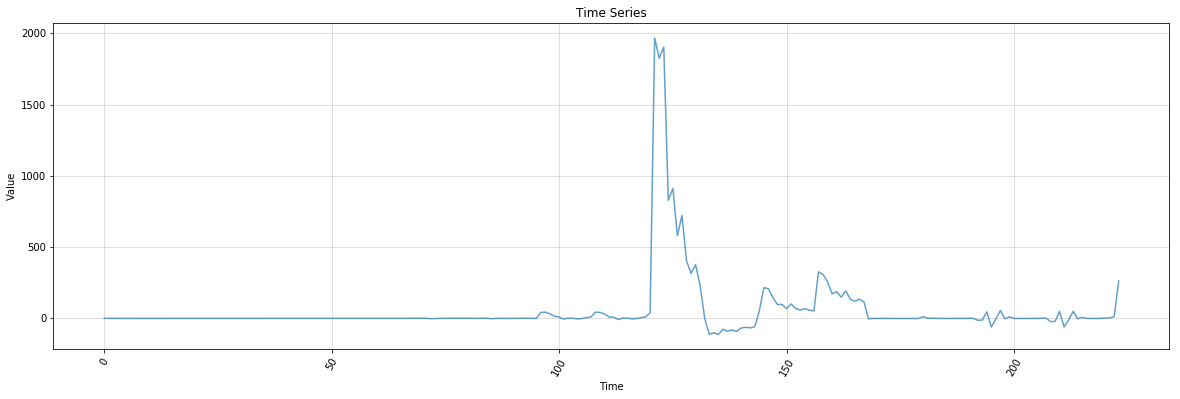

In [67]:
plot_temporal(2)

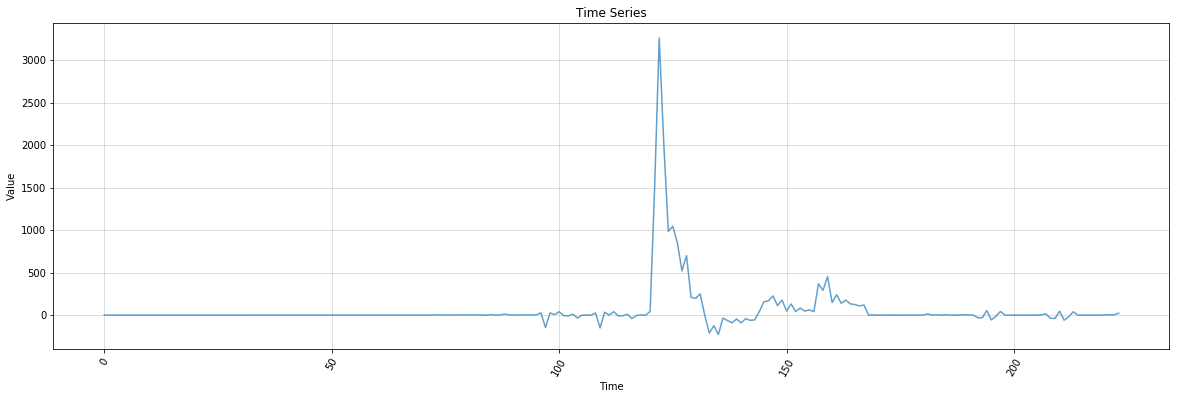

In [68]:
plot_temporal(4850)

<font color=darkblue>It would be nice to write all the pre-processed data in csv files for future use:</font>

In [69]:
df_trackinfo.to_csv("./Data/prepdata/trackinfo.csv", sep=',')
df_albums.to_csv("./Data/prepdata/Albums.csv", sep=',')
df_artist.to_csv("./Data/prepdata/Artist.csv", sep=',')
df_subset.to_csv("./Data/prepdata/Subset.csv", sep=',')
df_genres.to_csv("./Data/prepdata/Genres.csv", sep=',')
df_features.to_csv("./Data/prepdata/Stat_Features.csv", sep=',')
df_Audio_Features.to_csv("./Data/prepdata/Audio_Features.csv", sep=',')
df_Social_Features.to_csv("./Data/prepdata/Social_Features.csv", sep=',')
temporal_features.to_csv("./Data/prepdata/Temporal_Features.csv", sep=',')

## Data Processing  <a name="model"></a>

<font color=darkblue>Now that we have all the data gathered together, we can start the actual processing. In this section, we perform a study on how this data can be used. We have built multiple models for Genre classification which are presented in the seperate notebooks. Genre classification using waveform features is performed in GenrePrediction notebook and classification of genre using artists input is demontrated in ArtistInput notebook. Figure below shows the distinction between multiple genres based on the strength of the peaks in their audio files.</font>

<center><img src="./pics/beat.JPG" width="800" height= "600"/><em>Figure 3. Beat strength for 4 different genres extracted from mp3 audio files.</em></center>

<font color=darkblue>Datasets that we used for developing our models are 1) track-info which was provided by artists input and 2) the features extracted from the waveform of the mp3 audio files of each track. MFCC data were computed by using the middle 50% of the mp3 waveform and taking 20 ms frames at a parameterized interval. For each frame, data was multiplied by a hamming window to smooth the edges, and then Fourier Transform was performed to get the frequency components. Then frequencies were mapped to the mel scale, which models human perception of changes in pitch, which is approximately linear below 1kHz and logarithmic above 1kHz. This mapping groups the frequencies into 20 bins by
calculating triangle window coefficients based on the mel scale, multiplying that by the frequencies, and taking the log. Then by performing Discrete Cosine Transform, frequency components can be decorrelated. Finally, first 15 of these 20 frequencies were kept, since higher frequencies are the details that make less of a difference to human perception and contain less information about the song. Thus, each raw song waveform can be represented as a matrix of cepstral features, where each row is a vector of 15 cepstral frequencies of one 20 ms frame for a parameterized number of frames per song.</font>

<font color=darkblue> Figure below shows the flow chart of our process as well as the outcome of each model we built.</font>

<center><img src="./pics/Picture1.png" width="600" height= "500"/><em>Figure 3. Process flow chart and accuracy of each model.</em></center>

<font color=darkblue> Figure below shows best model that we developed considering both run time and accuracy. The full code and explanations can be find in GenrePrediction notebook in the main directory.</font>

<center><img src="./pics/model.png" width="900" height= "700"/><em>Figure 4. Best model output predictions and accuracy.</em></center>

## Genre Classification Application  <a name="application"></a>

<font color=darkblue>Now that we have our model we can build the data for a random song and test our model to get the closest genre for that particular song. In application notebook, we produced the features data for a Persian song and saved the data in a csv file "mysongfeatures.csv" in the main directory. In GenrePrediction notebook we will test the model on this new data. As we can see in the screenshot below(Figure 5), the closest genre for our traditional Persian Music is Old-Time/Historic which is a pretty good guess!</font>

In [78]:
filename = "./mp3Files/1.mp3"

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

Duration: 263.97s, 11640960 samples


In [79]:
plt.rcParams['figure.figsize'] = (17, 5)

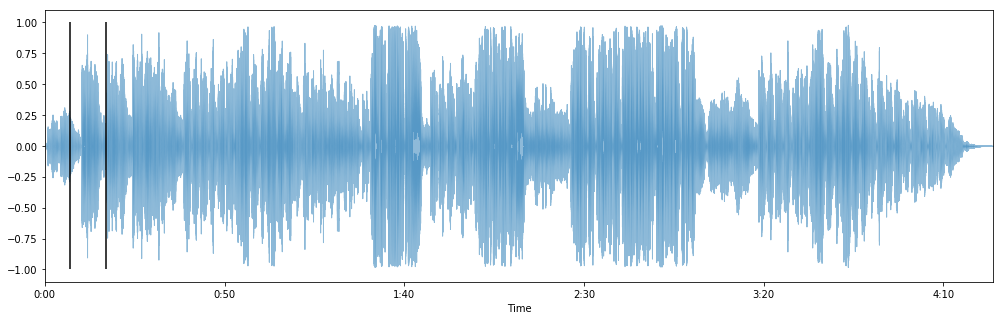

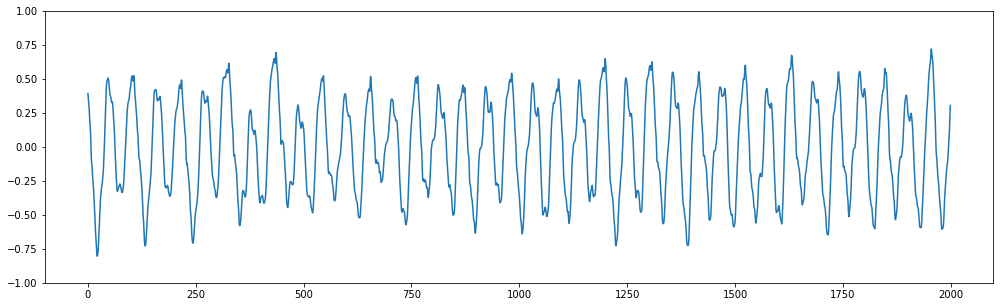

In [80]:
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

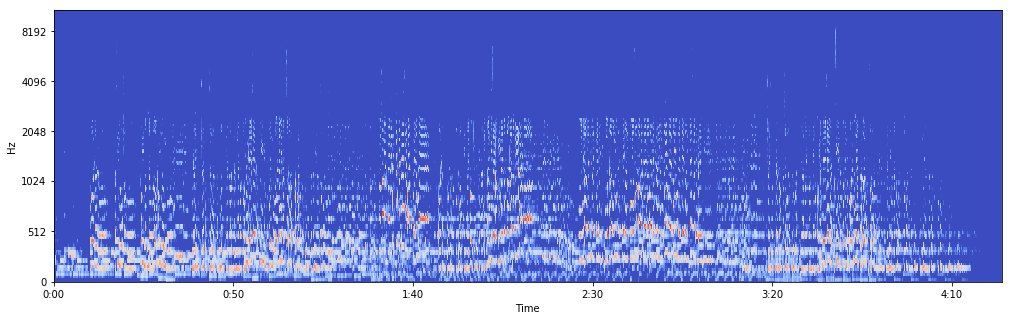

In [81]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

<center><img src="./pics/predict.png" width="900" height= "800"/><em>Figure 4. Genre Prediction for a traditional persian music track.</em></center>

## Appendix I: About the Members  <a name="bio"></a>

##### Farnaz:

Farnaz earned her B.Sc and M.Sc degree in Economics. The emphasis of her studies was on Econometrics and Quantitative modeling and analysis of large scale data. She is currently a master student in Economics department with a minor in Applied Data Science. Farnaz will be responsible for the theory of statistical concepts for the implementation of the our project.

##### Shideh:

Shideh is an Architectural Engineering Ph.D. student working with traffic data and implementing an energy efficient transportation model. Shideh is interested in applications of Machine Learning in transportation modeling. The computational data science minor at Drexel provides a strong foundation in this area, for both improving her Ph.D. research and learning the skills necessary for a future job. In this report, Shideh will be working on implementing a prediction model using machine learning techniques. 

##### Kiana:

Kiana is an electrical engineer working on novel low-dimensional materials with their application in photodetectors. She is planning to build a career as a data scientist. Kiana will be responsible for data cleaning and pre-processing, as well as intrepreting each dataset to be used toward our goal.